In [1]:
import os
import sys
import glob
import platform
import datetime
import numpy as np

from scipy import signal
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, leastsq

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
def flatter(data, polynomialOrder=15):

    ## Применяем медианную фильтрацию с максимальным шагом:
    res_filter = signal.medfilt(data, kernel_size=29)
    # Фитируем получившийся массив:
    xData = range(len(res_filter))
    yData = res_filter
    # curve fit the data
    fittedParameters = np.polyfit(xData, yData, polynomialOrder)
    xModel = np.linspace(min(xData), max(xData), len(xData))
    yModel = np.polyval(fittedParameters, xModel)

    return yModel

In [3]:
if 'Windows' in platform.platform() and '8.1' in platform.release():
    _ = "C:\\Users\\Andrey\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = None
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '7' in platform.release():
    _ = "E:\\Disk.Yandex\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "E:\\Disk.Yandex\\1.Работа\\Результаты обработки\\"
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '10' in platform.release():
    _ = "F:\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "F:\\YandexDisk\\1.Работа\\Результаты обработки\\"
    DELIMITER = "\\"
    
elif 'Linux' in platform.platform() and '4.4.0' in platform.release():
    _ = "/home/andr/Yandex.Disk/3.Programing/"
    DATA_DIR = _ + "work/PulseViewer/pulsarsData/"
    PATTERN_DIR = _ + "/work/PulseViewer/frame_of_AP/patterns/"
    PACK_DIR = _ + "myPacks/"
    ALL_DATA = "/home/andr/Yandex.Disk/1.Работа/Результаты обработки/"
    DELIMITER = "/"
    
else:
    print('unknown system', platform.platform(), platform.release())
    
sys.path.append(PACK_DIR)
from PRAO import *

In [4]:
name = '0531+21'
data = '02.03.2017'
day, month, year = data.split('.')

In [5]:
dir_file = (ALL_DATA  + name + DELIMITER + year + DELIMITER + month + year[2:] + DELIMITER)

In [6]:
files_txt = sorted(glob.glob(dir_file + day + month + year[2:] + '*' + name + '*_profiles.txt'))
files_srez = sorted(glob.glob(dir_file + day + month + year[2:] + '*' + name + '*.srez'))
files = np.append(files_txt, files_srez)

In [7]:
head, main_pulse, data_pulses, back = read_profiles_MD(files[0])

In [8]:
non_cor_data = []
for pulse, backg in zip(data_pulses, back):
    non_cor_data.append(pulse + backg)
obser = np.hstack(non_cor_data)

In [9]:
len(obser)

80520

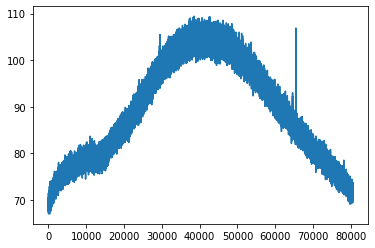

In [10]:
plt.close()
plt.plot(obser)
plt.show()

In [15]:
def sinxx(x):
    return (np.sin(x)/x)**2

In [12]:
fullpoints = int(head['numpuls'])*int(head['numpointwin'])
x = np.linspace(-1.37, 1.37, fullpoints)

In [13]:
obspoints = fullpoints - int(head['numpointwin'])
y = sinxx(x[:obspoints])

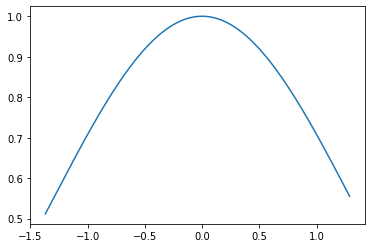

In [14]:
plt.close()
plt.plot(x[:obspoints], y)
plt.show()

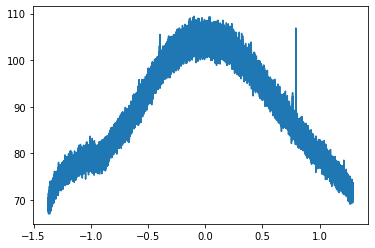

In [15]:
plt.close()
plt.plot(x[:obspoints], obser)
plt.show()

In [16]:
def beam_obs(x, amp,  shift, y0):
    return amp*(np.sin(x + shift)/(x + shift))**2 + y0

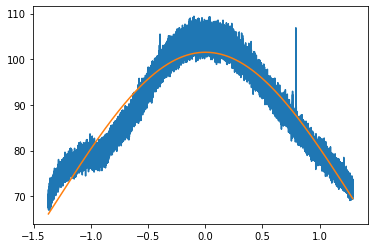

In [17]:
x = x[:obspoints]
poli = flatter(obser, 4)
max_calib = max(poli)
amp = max_calib
shift = 0
y0 = 50
popt,pcov = curve_fit(beam_obs,x,obser,p0=[amp,shift, y0])

plt.close()
plt.plot(x,obser, label='data')
plt.plot(x,beam_obs(x,*popt))
plt.show()

In [18]:
list_files = sorted(glob.glob('./good_days_full/*'))
date_list = [os.path.basename(i)[:10] for i in list_files]

Main object: 0531+21; Numbers of files: 3040
Main set: 0531+21; Numbers of files: 446


c:\users\professional\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ValError


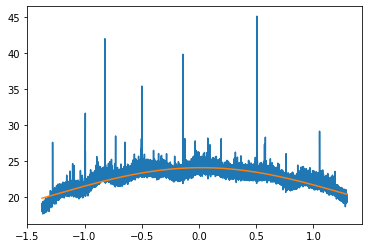

In [19]:
files_0531 = glob.glob(ALL_DATA + '0531+21'
                       + DELIMITER + '*' + DELIMITER + '*' + DELIMITER
                       + '*_profiles.txt')
print('Main object: 0531+21; Numbers of files: ' + str(len(files_0531)))

# установка диапазона дат
date_start = datetime.datetime(2018, 11, 20, 0, 0)
data_stop = datetime.datetime(2019, 11, 18, 0, 0)

main_set = [x for x in files_0531
             if date_start <= datetime.datetime.strptime(os.path.basename(x)[:6], '%d%m%y') <= data_stop]
print('Main set: 0531+21; Numbers of files: ' + str(len(main_set)))

idx_obs = 0
for file_name in main_set:
    try:
        head, main_pulse, data_pulses, back = read_profiles_MD(file_name)
        day, month, year = head['date'].split('.')
        if head['date'] in date_list:
            non_cor_data = []
            for pulse, backg in zip(data_pulses, back):
                non_cor_data.append(pulse + backg)
            obser = np.hstack(non_cor_data)
            
            fullpoints = int(head['numpuls'])*int(head['numpointwin'])
            x = np.linspace(-1.37, 1.37, fullpoints)
            obspoints = fullpoints - int(head['numpointwin'])
            x = x[:obspoints]
            poli = flatter(obser, 4)
            max_calib = max(poli)
            amp = max_calib
            shift = 0
            y0 = 50
            popt,pcov = curve_fit(beam_obs,x,obser,p0=[amp,shift, y0])

            plt.close()
            plt.plot(x,obser, label='data')
            plt.plot(x,beam_obs(x,*popt))
            plt.savefig(
                f".//sinxx_beam_cmensation//{year}.{month}.{day}_obs_plot_0531+21.png",
                format='png',
                dpi=100)
            
    except ValueError:
        print('ValError')
    except OSError:
        print('OsError')

In [18]:
obser

array([67.5849, 69.4995, 68.8   , ..., 72.4947, 72.7446, 71.5741])

## Отработка алгоритма калибровки

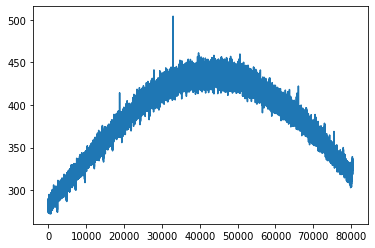

In [45]:
name = '0531+21'
data = '14.09.2013'
day, month, year = data.split('.')

dir_file = (ALL_DATA  + name + DELIMITER + year + DELIMITER + month + year[2:] + DELIMITER)

files_txt = sorted(glob.glob(dir_file + day + month + year[2:] + '*' + name + '*_profiles.txt'))
files_srez = sorted(glob.glob(dir_file + day + month + year[2:] + '*' + name + '*.srez'))
files = np.append(files_txt, files_srez)

head, main_pulse, data_pulses, back = read_profiles_MD(files[0])

non_cor_data = []
for pulse, backg in zip(data_pulses, back):
    non_cor_data.append(pulse + backg)
obser = np.hstack(non_cor_data)

plt.close()
plt.plot(obser)
plt.show()

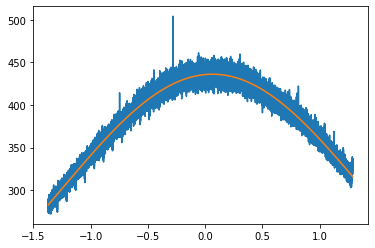

In [46]:
fullpoints = int(head['numpuls'])*int(head['numpointwin'])
x = np.linspace(-1.37, 1.37, fullpoints)

obspoints = fullpoints - int(head['numpointwin'])
y = sinxx(x[:obspoints])

x = x[:obspoints]
poli = flatter(obser, 4)
max_calib = max(poli)
amp = max_calib
shift = 0
y0 = 50
popt,pcov = curve_fit(beam_obs,x,obser,p0=[amp,shift, y0])

plt.close()
plt.plot(x,obser, label='data')
plt.plot(x,beam_obs(x,*popt))
plt.show()

In [47]:
popt

array([ 2.93515943e+02, -6.47705605e-02,  1.42701760e+02])

In [48]:
1720/(amp - popt[2])

5.863585230307352

In [49]:
amp

436.037651250079

In [50]:
popt[2]

142.7017599067136

## Компенсация диаграммы

In [51]:
beam_coeff = beam_obs(x,*popt)
coeff = 1720/(amp - popt[2])
obser = coeff*obser
y0_back = popt[2]*coeff

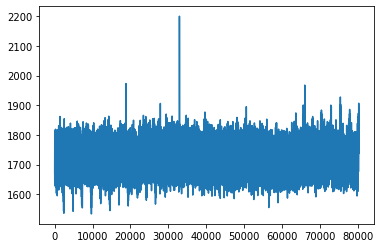

In [52]:
cor_d = []
for data_point, coeff in zip(obser, beam_coeff/np.max(beam_coeff)):
    cor_d.append(data_point/coeff)
cor_d = np.asarray(cor_d)

plt.close()
plt.plot(cor_d - y0_back)
plt.show()

In [53]:
np.median(cor_d - y0_back)

1720.6372131612595

In [32]:
popt[2]

142.7017599067136